In [7]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
import numpy as np
from astropy.table import Table
from astropy.units import Quantity
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.point_sources import PointSources
from slsim.Sources.QuasarCatalog.quasar_pop import QuasarRate
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from slsim.Sources.source import Source
from slsim.image_simulation import point_source_coordinate_properties
from slsim.image_simulation import lens_image_series, rgb_image_from_image_list
from slsim.Plots.plot_functions import create_image_montage_from_image_list
import math

## Supernovae plus extended source simulation
In this notebook, we simulate population of lensed supernovae and simulate image of a 

random lensed supernovae. It follows following steps:

1. Simulate lensed supernovae population
2. Choose a lens at random
3. Set observation time and other image configuration
4. Simulate image of a selected lens
5. Visualize it

Before running this notebook, please download the "scotch_SNIa_host_galaxies.fits"

file from the following link: https://github.com/LSST-strong-lensing/data_public.git. 

This file contains type Ia supernovae host galaxies.

## Simulate lensed supernovae population

In [19]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
deflector_sky_area = Quantity(value=2, unit="deg2")
source_sky_area = Quantity(value=5, unit="deg2")
sky_area = Quantity(value=2000, unit="deg2")

kwargs_deflector_cut = {"band": "g", "band_max": 24, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"z_min": 0.1, "z_max": 5.0}

time_range = np.linspace(-50, 100, 500)


In [3]:
# Generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area, filters=None, cosmo=cosmo
)

In [4]:
# Initiate deflector population class.
lens_galaxies = deflectors.AllLensGalaxies(
    red_galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    blue_galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light=None,
    cosmo=cosmo,
    sky_area=sky_area,
)

/Users/narayankhadka/slsim/slsim/Deflectors/all_lens_galaxies.py:54: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/Users/narayankhadka/slsim/slsim/Deflectors/all_lens_galaxies.py:57: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [16]:
supernovae_catalog = sources.SupernovaeCatalog.SupernovaeCatalog(
    sn_type="Ia",
    band_list=["i"],
    lightcurve_time=time_range,
    absolute_mag_band="bessellb",
    absolute_mag=None,
    mag_zpsys="ab",
    cosmo=cosmo,
    skypy_config=None,
    sky_area=source_sky_area,
)
supernovae_data = supernovae_catalog.supernovae_catalog(
    host_galaxy=False, lightcurve=False
)

In [17]:
# Initiate source population class.
supernovae_sourece = sources.PointSources(
    point_source_list=supernovae_data,
    cosmo=cosmo,
    sky_area=source_sky_area,
    kwargs_cut=kwargs_source_cut,
    variability_model="light_curve",
    kwargs_variability_model={"supernovae_lightcurve", "i", "r", "g"},
    lightcurve_time=time_range,
    sn_type="Ia",
    sn_absolute_mag_band="bessellb",
    sn_absolute_zpsys="ab",
)

In [20]:
# Initiate LensPop class
supernova_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=supernovae_sourece,
    sky_area=sky_area,
    cosmo=cosmo
)

## Draw lens population

In [22]:
# specifying cuts of the population
kwargs_lens_cuts = {}
# drawing population
supernovae_lens_population = supernova_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cuts, speed_factor=100, multi_source=False
)

## Choose a lens to simulate an image

In [25]:
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class = supernovae_lens_population[0]

In [26]:
pix_coord = point_source_coordinate_properties(
    lens_class,
    band="i",
    mag_zero_point=27,
    delta_pix=0.2,
    num_pix=32,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)["image_pix"]

/Users/narayankhadka/slsim/slsim/Sources/supernovae.py:109: UserWarning: bandpass 'lsstg' [3866, .., 5670] outside spectral range [4231.25, .., 42312.5]
Ignoring bandpass for now. Use extended wavelength SN models found here: https://github.com/LSST-strong-lensing/data_public/tree/main/sncosmo_sn_models
  warn(
/opt/anaconda3/lib/python3.9/site-packages/sncosmo/models.py:189: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


In [36]:
pix_coord

[array([[18.28767419, 11.13214571]]), array([[14.84482128, 15.23258164]])]

## See the light curve of a selected supernovae

In [29]:
light_curve = lens_class.source[0].variability_class.kwargs_model

(-22.0, 100.0)

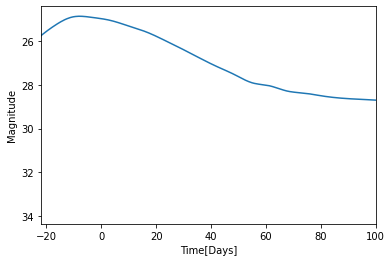

In [30]:
plt.plot(light_curve["MJD"], light_curve["ps_mag_i"])
# plt.ylim(12, 18)
plt.gca().invert_yaxis()
plt.ylabel("Magnitude")
plt.xlabel("Time" "[Days]")
plt.xlim(-22, 100)

## Set observation time and image configuration

In [31]:
time = np.array([-19.5, -15, -11.35135135135135, 0, 10, 20, 25, 30, 40, 44.86])
# time = sorted(np.random.uniform(-20, 100, 10))
# time = np.array([0, 50, 70, 120])
repeats = 10
# load your psf kernel and transform matrix. If you have your own psf, please provide
# it here.
path = "../tests/TestData/psf_kernels_for_deflector.npy"
psf_kernel = 1 * np.load(path)
psf_kernel[psf_kernel < 0] = 0
transform_matrix = np.array([[0.2, 0], [0, 0.2]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [psf_kernel]
transform_matrix_list = [transform_matrix]
psf_kernels_all = psf_kernel_list * repeats
# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.
transform_matrix_all = transform_matrix_list * repeats

# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
mag_list = [31.0]
mag_zero_points_all = mag_list * repeats
# mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

expo_list = [30]
exposure_time_all = expo_list * repeats

## Simulate Image

In [32]:
# Simulate a lens image
image_lens_series = lens_image_series(
    lens_class=lens_class,
    band="i",
    mag_zero_point=mag_zero_points_all,
    num_pix=32,
    psf_kernel=psf_kernels_all,
    transform_pix2angle=transform_matrix_all,
    exposure_time=exposure_time_all,
    t_obs=time,
    with_deflector=True,
    with_source=True,
)

In [33]:
## Images in log scale
log_images = []
for i in range(len(image_lens_series)):
    log_images.append(np.log10(image_lens_series[i]))

## Visualize simulated images

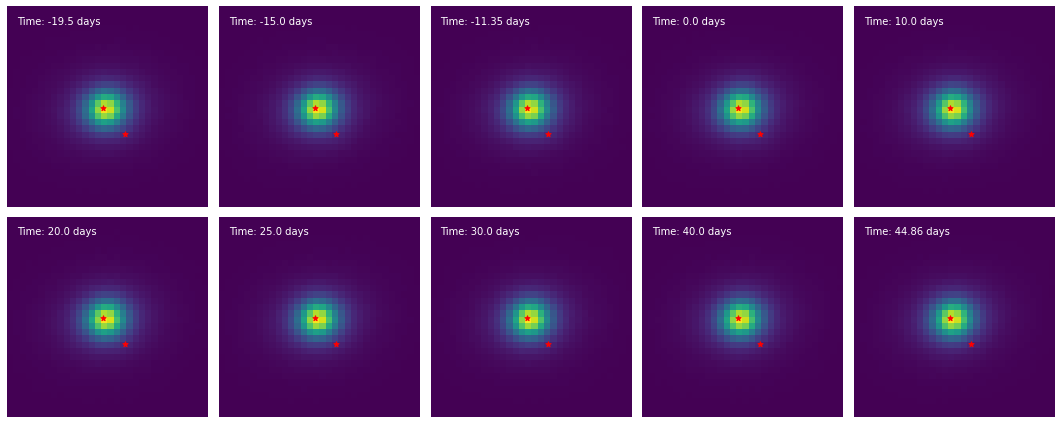

In [41]:
plot_montage = create_image_montage_from_image_list(
    num_rows=2, num_cols=5, images=image_lens_series, time=time,
      image_center=[pix_coord[0][0], pix_coord[1][0]]
)